# Monday, December 2nd, 2024

Example using `requests` and `re` to pull data from a webpage:

In [1]:
url = r'https://www.transfermarkt.us/everton-fc/kader/verein/29/saison_id/2024/plus/1'

In [2]:
import requests, re

In [3]:
headers = {'User-Agent':'Mozilla/5.0'}

In [4]:
page = requests.get(url,headers=headers)
text = page.text

In [5]:
#print(text)

It looks like the HTML code `<tr class="odd">` or `<tr class="even">` preceeds information about each player, so let's try splitting on this code to generate blocks of player information.

In [6]:
s = 'Twelve is an even number, 14 is an odd number. 15 is even.'


re.findall(r'an (?:odd|even)', s)

['an even', 'an odd']

In [7]:
player_info_pattern = r'<tr class="(?:odd|even)">'

player_info_blocks = re.split(player_info_pattern, text)[1:]

In [8]:
help(re.split)

Help on function split in module re:

split(pattern, string, maxsplit=0, flags=0)
    Split the source string by the occurrences of the pattern,
    returning a list containing the resulting substrings.  If
    capturing parentheses are used in pattern, then the text of all
    groups in the pattern are also returned as part of the resulting
    list.  If maxsplit is nonzero, at most maxsplit splits occur,
    and the remainder of the string is returned as the final element
    of the list.



In [135]:
player_info_block = player_info_blocks[10]

print(player_info_block)


<td class="zentriert rueckennummer bg_Abwehr" title="Defender"><div class=rn_nummer>23</div></td><td class="posrela">
<table class="inline-table">
    <tr>
        <td rowspan="2">
                    </td>
        <td class="hauptlink">
            <a href="/seamus-coleman/profil/spieler/68390">
                Séamus Coleman<span title="Team captain" class="kapitaenicon-table icons_sprite">&nbsp;</span>            </a>
        </td>
    </tr>
    <tr>
        <td>
            Right-Back        </td>
    </tr>
</table>
</td><td class="zentriert">Oct 11, 1988 (36)</td><td class="zentriert"><img src="https://tmssl.akamaized.net//images/flagge/verysmall/72.png?lm=1520611569" title="Ireland" alt="Ireland" class="flaggenrahmen" /></td><td class="zentriert">1,77m</td><td class="zentriert">right</td><td class="zentriert">Jan 1, 2009</td><td class="zentriert"><a title="Sligo Rovers: Ablöse €70k" href="/sligo-rovers/startseite/verein/8780/saison_id/2008"><img src="https://tmssl.akamaized.net/

Player number information looks to be of the form: `<div class=rn_nummer>(SOME NUMBER HER)</div>`

In [137]:
player_number_pattern = r'<div class=rn_nummer>(\d+)</div>'
number = re.findall(player_number_pattern, player_info_block)[0]

print(number)

23


The structure for finding names is:
 - `<td class="hauptlink">`
 - `<a href=...>`
 - THE NAME
 - `</a>`

In [138]:
player_name_pattern = r'<td class="hauptlink">\s*<a href=.+>\s*(.+?)<'

player_name = re.findall(player_name_pattern, player_info_block)[0].strip()

print(player_name)

Séamus Coleman


Player position information looks to be of the form `<tr>(WHITE SPACE)<td>(WHITE SPACE)POSITION(WHITE SPACE)</td>(WHITE SPACE)</tr>`

In [136]:
player_position_pattern = r'<tr>\s*<td>\s*(.+)\s*</td>\s*</tr>'

position = re.findall(player_position_pattern, player_info_block)[0].strip()
print(position)

Right-Back


It looks like each piece of data is separated by the HTML `<td class="zentriert">`, so let's split on this string.

In [139]:
for piece in player_info_block.split(r'<td class="zentriert">')[1:]:
    print(piece)

Oct 11, 1988 (36)</td>
<img src="https://tmssl.akamaized.net//images/flagge/verysmall/72.png?lm=1520611569" title="Ireland" alt="Ireland" class="flaggenrahmen" /></td>
1,77m</td>
right</td>
Jan 1, 2009</td>
<a title="Sligo Rovers: Ablöse €70k" href="/sligo-rovers/startseite/verein/8780/saison_id/2008"><img src="https://tmssl.akamaized.net//images/wappen/verysmall/8780.png?lm=1498249702" title="Sligo Rovers" alt="Sligo Rovers" class="" /></a></td>
Jun 30, 2025</td><td class="rechts hauptlink"><a href="/seamus-coleman/marktwertverlauf/spieler/68390">€500k</a></td></tr>



The ordering of these pieces are:
 - Age
 - Nationality
 - Height 
 - Preferred foot
 - When they signed
 - Where they signed from and for how much
 - Contract expiration and market value

In [140]:
(age_info, 
nationality_info, 
height_info, 
foot_info, 
sign_date_info, 
sign_from_info, 
contract_info) = player_info_block.split(r'<td class="zentriert">')[1:]

In [141]:
print(age_info)

Oct 11, 1988 (36)</td>


In [142]:
birthdate_pattern = r'\w{3} \d+, \d{4}'
age_pattern = r'\((\d+)\)'

birthdate = re.findall(birthdate_pattern,age_info)[0]
age = re.findall(age_pattern, age_info)[0]

print(birthdate)
print(age)

Oct 11, 1988
36


In [143]:
print(nationality_info)

<img src="https://tmssl.akamaized.net//images/flagge/verysmall/72.png?lm=1520611569" title="Ireland" alt="Ireland" class="flaggenrahmen" /></td>


In [144]:
nationality_pattern = r'title="(\w+)"'

nationality = re.findall(nationality_pattern, nationality_info)[0]
print(nationality)

Ireland


In [145]:
print(height_info)

1,77m</td>


In [146]:
height_pattern = r'\d+,\d+m'

height = re.findall(height_pattern, height_info)[0]
print(height)

1,77m


In [147]:
print(foot_info)

right</td>


In [148]:
foot_pattern = r'(\w+)<'

foot = re.findall(foot_pattern, foot_info)[0]
print(foot)

right


In [149]:
print(sign_date_info)

Jan 1, 2009</td>


In [150]:
sign_date_pattern = r'\w{3} \d+, \d{4}'

sign_date = re.findall(sign_date_pattern, sign_date_info)[0]
print(sign_date)

Jan 1, 2009


In [151]:
print(sign_from_info)

<a title="Sligo Rovers: Ablöse €70k" href="/sligo-rovers/startseite/verein/8780/saison_id/2008"><img src="https://tmssl.akamaized.net//images/wappen/verysmall/8780.png?lm=1498249702" title="Sligo Rovers" alt="Sligo Rovers" class="" /></a></td>


In [152]:
sign_from_pattern = r'<a title="(.+): Ablöse (.+)" href'

sign_from, sign_fee = re.findall(sign_from_pattern, sign_from_info)[0]
print(sign_from)
print(sign_fee)

Sligo Rovers
€70k


In [153]:
print(contract_info)

Jun 30, 2025</td><td class="rechts hauptlink"><a href="/seamus-coleman/marktwertverlauf/spieler/68390">€500k</a></td></tr>



In [154]:
contract_end_pattern = r'\w{3} \d+, \d{4}'

contract_end = re.findall(contract_end_pattern, contract_info)[0]
print(contract_end)

market_value_pattern = r'(€.+?)<'

market_value = re.findall(market_value_pattern, contract_info)[0]
print(market_value)

Jun 30, 2025
€500k


Let's assemble all of these patterns and searches into a function.

In [8]:
player_name_pattern = r'<td class="hauptlink">\s*<a href=.+>\s*(.+?)<'
player_number_pattern = r'<div class=rn_nummer>(\d+)</div>'
player_position_pattern = r'<tr>\s*<td>\s*(.+)\s*</td>\s*</tr>'

birthdate_pattern = r'\w{3} \d+, \d{4}'
age_pattern = r'\((\d+)\)'
nationality_pattern = r'title="(\w+)"'
height_pattern = r'\d+,\d+m'
foot_pattern = r'(\w+)<'
sign_date_pattern = r'\w{3} \d+, \d{4}'
sign_from_pattern = r'<a title="(.+): Ablöse (.+)" href'
contract_end_pattern = r'\w{3} \d+, \d{4}'
market_value_pattern = r'(€.+?)<'

def get_player_info(player_info_block):
    (age_info, 
    nationality_info, 
    height_info, 
    foot_info, 
    sign_date_info, 
    sign_from_info, 
    contract_info) = player_info_block.split(r'<td class="zentriert">')[1:]

    name = re.findall(player_name_pattern, player_info_block)[0].strip()
    number = re.findall(player_number_pattern, player_info_block)[0]
    position = re.findall(player_position_pattern, player_info_block)[0].strip()
    
    birthdate = re.findall(birthdate_pattern,age_info)[0]
    age = re.findall(age_pattern, age_info)[0]
    
    nationality = re.findall(nationality_pattern, nationality_info)[0]
    
    height = re.findall(height_pattern, height_info)[0]
    
    foot = re.findall(foot_pattern, foot_info)[0]
    
    sign_date = re.findall(sign_date_pattern, sign_date_info)[0]
    
    sign_from, sign_fee = re.findall(sign_from_pattern, sign_from_info)[0]
    
    contract_end = re.findall(contract_end_pattern, contract_info)[0]
    market_value = re.findall(market_value_pattern, contract_info)[0]
    
    return (name, number, position, birthdate, age, nationality, height, foot,
            sign_date, sign_from, sign_fee, contract_end, market_value)

In [9]:
get_player_info(player_info_blocks[0])

('Jordan Pickford',
 '1',
 'Goalkeeper',
 'Mar 7, 1994',
 '30',
 'England',
 '1,85m',
 'left',
 'Jul 1, 2017',
 'Sunderland AFC',
 '€28.50m',
 'Jun 30, 2027',
 '€22.00m')

In [10]:
for player_info_block in player_info_blocks:
    print(get_player_info(player_info_block))

('Jordan Pickford', '1', 'Goalkeeper', 'Mar 7, 1994', '30', 'England', '1,85m', 'left', 'Jul 1, 2017', 'Sunderland AFC', '€28.50m', 'Jun 30, 2027', '€22.00m')
('João Virgínia', '12', 'Goalkeeper', 'Oct 10, 1999', '25', 'Portugal', '1,92m', 'left', 'Jul 1, 2020', 'Everton FC U23', '-', 'Jun 30, 2025', '€800k')
('Asmir Begovic', '31', 'Goalkeeper', 'Jun 20, 1987', '37', 'Canada', '1,99m', 'right', 'Aug 23, 2024', 'Queens Park Rangers', 'free transfer', 'Jun 30, 2025', '€300k')
('Jarrad Branthwaite', '32', 'Centre-Back', 'Jun 27, 2002', '22', 'England', '1,95m', 'left', 'Jan 13, 2020', 'Carlisle United', '€1.10m', 'Jun 30, 2027', '€42.00m')
("Jake O'Brien", '15', 'Centre-Back', 'May 15, 2001', '23', 'Ireland', '1,97m', 'right', 'Jul 30, 2024', 'Olympique Lyon', '€19.50m', 'Jun 30, 2028', '€15.00m')
('James Tarkowski', '6', 'Centre-Back', 'Nov 19, 1992', '32', 'England', '1,85m', 'right', 'Jul 2, 2022', 'Burnley FC', 'free transfer', 'Jun 30, 2026', '€13.00m')
('Michael Keane', '5', 'Centr

In [11]:
names = []
numbers = []
positions = []
birthdates = []
ages = []
nationalities = []
heights = []
foots = []
sign_dates = []
sign_froms = []
sign_fees = []
contract_ends = []
market_values = []

for player_info_block in player_info_blocks:
    (name, number, position, birthdate, age, nationality, height, foot,
    sign_date, sign_from, sign_fee, contract_end, market_value) = get_player_info(player_info_block)
    
    names.append(name)
    numbers.append(number)
    positions.append(position)
    birthdates.append(birthdate)
    ages.append(age)
    nationalities.append(nationality)
    heights.append(height)
    foots.append(foot)
    sign_dates.append(sign_date)
    sign_froms.append(sign_from)
    sign_fees.append(sign_fee)
    contract_ends.append(contract_end)
    market_values.append(market_value)

In [12]:
import pandas as pd

In [13]:
player_df = pd.DataFrame({'Name':names,
                          'Number':numbers,
                          'Position':positions,
                          'Birthdate':birthdates,
                          'Age':ages,
                          'Nationality':nationalities,
                          'Height':heights,
                          'Preferred foot':foots,
                          'Date signed':sign_dates,
                          'Transfer fee':sign_fees,
                          'Contract expiration':contract_end,
                          'Market value':market_values})

In [14]:
player_df

,Name,Number,Position,Birthdate,Age,Nationality,Height,Preferred foot,Date signed,Transfer fee,Contract expiration,Market value
0,Jordan Pickford,1,Goalkeeper,"Mar 7, 1994",30,England,"1,85m",left,"Jul 1, 2017",€28.50m,"Jun 30, 2027",€22.00m
1,João Virgínia,12,Goalkeeper,"Oct 10, 1999",25,Portugal,"1,92m",left,"Jul 1, 2020",-,"Jun 30, 2027",€800k
2,Asmir Begovic,31,Goalkeeper,"Jun 20, 1987",37,Canada,"1,99m",right,"Aug 23, 2024",free transfer,"Jun 30, 2027",€300k
3,Jarrad Branthwaite,32,Centre-Back,"Jun 27, 2002",22,England,"1,95m",left,"Jan 13, 2020",€1.10m,"Jun 30, 2027",€42.00m
4,Jake O'Brien,15,Centre-Back,"May 15, 2001",23,Ireland,"1,97m",right,"Jul 30, 2024",€19.50m,"Jun 30, 2027",€15.00m
5,James Tarkowski,6,Centre-Back,"Nov 19, 1992",32,England,"1,85m",right,"Jul 2, 2022",free transfer,"Jun 30, 2027",€13.00m
6,Michael Keane,5,Centre-Back,"Jan 11, 1993",31,England,"1,88m",right,"Jul 3, 2017",€28.50m,"Jun 30, 2027",€6.00m
7,Vitaliy Mykolenko,19,Left-Back,"May 29, 1999",25,Ukraine,"1,80m",left,"Jan 1, 2022",€23.50m,"Jun 30, 2027",€28.00m
8,Ashley Young,18,Left-Back,"Jul 9, 1985",39,England,"1,75m",both,"Jul 13, 2023",free transfer,"Jun 30, 2027",€500k
9,Nathan Patterson,2,Right-Back,"Oct 16, 2001",23,Scotland,"1,89m",right,"Jan 4, 2022",€14.00m,"Jun 30, 2027",€15.00m


In [15]:
player_df.loc[player_df['Age'].astype(int) > 30]

,Name,Number,Position,Birthdate,Age,Nationality,Height,Preferred foot,Date signed,Transfer fee,Contract expiration,Market value
2,Asmir Begovic,31,Goalkeeper,"Jun 20, 1987",37,Canada,"1,99m",right,"Aug 23, 2024",free transfer,"Jun 30, 2027",€300k
5,James Tarkowski,6,Centre-Back,"Nov 19, 1992",32,England,"1,85m",right,"Jul 2, 2022",free transfer,"Jun 30, 2027",€13.00m
6,Michael Keane,5,Centre-Back,"Jan 11, 1993",31,England,"1,88m",right,"Jul 3, 2017",€28.50m,"Jun 30, 2027",€6.00m
8,Ashley Young,18,Left-Back,"Jul 9, 1985",39,England,"1,75m",both,"Jul 13, 2023",free transfer,"Jun 30, 2027",€500k
10,Séamus Coleman,23,Right-Back,"Oct 11, 1988",36,Ireland,"1,77m",right,"Jan 1, 2009",€70k,"Jun 30, 2027",€500k
13,Abdoulaye Doucouré,16,Central Midfield,"Jan 1, 1993",31,Mali,"1,83m",right,"Sep 8, 2020",€22.00m,"Jun 30, 2027",€10.00m
15,Idrissa Gueye,27,Central Midfield,"Sep 26, 1989",35,Senegal,"1,74m",right,"Sep 1, 2022",€4.00m,"Jun 30, 2027",€2.00m


In [16]:
player_df.to_csv('Everton.csv')

# Wednesday, December 4th, 2024

## Summary of results from Monday:

In [3]:
import requests, re

In [4]:
url = r'https://www.transfermarkt.us/everton-fc/kader/verein/29/saison_id/2024/plus/1'

headers = {'User-Agent':'Mozilla/5.0'}
page = requests.get(url,headers=headers)
text = page.text

In [5]:
player_info_pattern = r'<tr class="(?:odd|even)">'
player_info_blocks = re.split(player_info_pattern, text)[1:]

In [6]:
player_name_pattern = r'<td class="hauptlink">\s*<a href=.+>\s*(.+?)<'
player_number_pattern = r'<div class=rn_nummer>(\d+)</div>'
player_position_pattern = r'<tr>\s*<td>\s*(.+)\s*</td>\s*</tr>'

birthdate_pattern = r'\w{3} \d+, \d{4}'
age_pattern = r'\((\d+)\)'
nationality_pattern = r'title="(\w+)"'
height_pattern = r'\d+,\d+m'
foot_pattern = r'(\w+)<'
sign_date_pattern = r'\w{3} \d+, \d{4}'
sign_from_pattern = r'<a title="(.+): Ablöse (.+)" href'
contract_end_pattern = r'\w{3} \d+, \d{4}'
market_value_pattern = r'(€.+?)<'

def get_player_info(player_info_block):
    (age_info, 
    nationality_info, 
    height_info, 
    foot_info, 
    sign_date_info, 
    sign_from_info, 
    contract_info) = player_info_block.split(r'<td class="zentriert">')[1:]

    name = re.findall(player_name_pattern, player_info_block)[0].strip()
    number = re.findall(player_number_pattern, player_info_block)[0]
    position = re.findall(player_position_pattern, player_info_block)[0].strip()
    
    birthdate = re.findall(birthdate_pattern,age_info)[0]
    age = re.findall(age_pattern, age_info)[0]
    
    nationality = re.findall(nationality_pattern, nationality_info)[0]
    
    height = re.findall(height_pattern, height_info)[0]
    
    foot = re.findall(foot_pattern, foot_info)[0]
    
    sign_date = re.findall(sign_date_pattern, sign_date_info)[0]
    
    sign_from, sign_fee = re.findall(sign_from_pattern, sign_from_info)[0]
    
    contract_end = re.findall(contract_end_pattern, contract_info)[0]
    market_value = re.findall(market_value_pattern, contract_info)[0]
    
    return (name, number, position, birthdate, age, nationality, height, foot,
            sign_date, sign_from, sign_fee, contract_end, market_value)

In [7]:
names = []
numbers = []
positions = []
birthdates = []
ages = []
nationalities = []
heights = []
foots = []
sign_dates = []
sign_froms = []
sign_fees = []
contract_ends = []
market_values = []

for player_info_block in player_info_blocks:
    (name, number, position, birthdate, age, nationality, height, foot,
    sign_date, sign_from, sign_fee, contract_end, market_value) = get_player_info(player_info_block)
    
    names.append(name)
    numbers.append(number)
    positions.append(position)
    birthdates.append(birthdate)
    ages.append(age)
    nationalities.append(nationality)
    heights.append(height)
    foots.append(foot)
    sign_dates.append(sign_date)
    sign_froms.append(sign_from)
    sign_fees.append(sign_fee)
    contract_ends.append(contract_end)
    market_values.append(market_value)

## Working with Pandas:

In [8]:
import pandas as pd

In [21]:
player_df = pd.DataFrame({'Name':names,
                          'Number':numbers,
                          'Position':positions,
                          'Birthdate':birthdates,
                          'Age':ages,
                          'Nationality':nationalities,
                          'Height':heights,
                          'Preferred foot':foots,
                          'Date signed':sign_dates,
                          'Transfer fee':sign_fees,
                          'Contract expiration':contract_end,
                          'Market value':market_values})

We can also use `pd.read_csv` to load in a saved file:

In [22]:
#player_df = pd.read_csv('Everton.csv', index_col=0)

In [23]:
player_df

,Name,Number,Position,Birthdate,Age,Nationality,Height,Preferred foot,Date signed,Transfer fee,Contract expiration,Market value
0,Jordan Pickford,1,Goalkeeper,"Mar 7, 1994",30,England,"1,85m",left,"Jul 1, 2017",€28.50m,"Jun 30, 2027",€22.00m
1,João Virgínia,12,Goalkeeper,"Oct 10, 1999",25,Portugal,"1,92m",left,"Jul 1, 2020",-,"Jun 30, 2027",€800k
2,Asmir Begovic,31,Goalkeeper,"Jun 20, 1987",37,Canada,"1,99m",right,"Aug 23, 2024",free transfer,"Jun 30, 2027",€300k
3,Jarrad Branthwaite,32,Centre-Back,"Jun 27, 2002",22,England,"1,95m",left,"Jan 13, 2020",€1.10m,"Jun 30, 2027",€42.00m
4,Jake O'Brien,15,Centre-Back,"May 15, 2001",23,Ireland,"1,97m",right,"Jul 30, 2024",€19.50m,"Jun 30, 2027",€15.00m
5,James Tarkowski,6,Centre-Back,"Nov 19, 1992",32,England,"1,85m",right,"Jul 2, 2022",free transfer,"Jun 30, 2027",€13.00m
6,Michael Keane,5,Centre-Back,"Jan 11, 1993",31,England,"1,88m",right,"Jul 3, 2017",€28.50m,"Jun 30, 2027",€6.00m
7,Vitaliy Mykolenko,19,Left-Back,"May 29, 1999",25,Ukraine,"1,80m",left,"Jan 1, 2022",€23.50m,"Jun 30, 2027",€28.00m
8,Ashley Young,18,Left-Back,"Jul 9, 1985",39,England,"1,75m",both,"Jul 13, 2023",free transfer,"Jun 30, 2027",€500k
9,Nathan Patterson,2,Right-Back,"Oct 16, 2001",23,Scotland,"1,89m",right,"Jan 4, 2022",€14.00m,"Jun 30, 2027",€15.00m


All of these columns are stored as strings (when we pulled data directly from the webpage).

We can access columns just like accessing elements of a dictionary:

In [24]:
player_df['Age']

0     30
1     25
2     37
3     22
4     23
5     32
6     31
7     25
8     39
9     23
10    36
11    23
12    26
13    31
14    21
15    35
16    25
17    24
18    24
19    28
20    27
21    26
22    23
23    20
Name: Age, dtype: object

We can use the `.astype` method to convert the datatype of a column.

In [25]:
player_df['Age'].astype(int)

0     30
1     25
2     37
3     22
4     23
5     32
6     31
7     25
8     39
9     23
10    36
11    23
12    26
13    31
14    21
15    35
16    25
17    24
18    24
19    28
20    27
21    26
22    23
23    20
Name: Age, dtype: int32

We can then store these results back in the dataframe:

In [27]:
player_df['Age'] = player_df['Age'].astype(int)
player_df['Number'] = player_df['Number'].astype(int)

The height column isn't quite a float, but it represents some numeric data. Can we adjust this formatting so that we could process it numerically?

In [28]:
player_df['Height']

0     1,85m
1     1,92m
2     1,99m
3     1,95m
4     1,97m
5     1,85m
6     1,88m
7     1,80m
8     1,75m
9     1,89m
10    1,77m
11    1,82m
12    1,78m
13    1,83m
14    1,83m
15    1,74m
16    1,83m
17    1,80m
18    1,82m
19    1,75m
20    1,89m
21    1,94m
22    1,91m
23    1,92m
Name: Height, dtype: object

We can gain access to string functions (like `replace`, `split`, etc.) using the `.str` attribute:

In [32]:
player_df['Height'].str.replace(',','.').str.replace('m','').astype(float)

0     1.85
1     1.92
2     1.99
3     1.95
4     1.97
5     1.85
6     1.88
7     1.80
8     1.75
9     1.89
10    1.77
11    1.82
12    1.78
13    1.83
14    1.83
15    1.74
16    1.83
17    1.80
18    1.82
19    1.75
20    1.89
21    1.94
22    1.91
23    1.92
Name: Height, dtype: float64

Let's update our Height data to be of float type, and then we'll move the units (meters) into the column label.

In [33]:
player_df['Height'] = player_df['Height'].str.replace(',','.').str.replace('m','').astype(float)

In [34]:
player_df

,Name,Number,Position,Birthdate,Age,Nationality,Height,Preferred foot,Date signed,Transfer fee,Contract expiration,Market value
0,Jordan Pickford,1,Goalkeeper,"Mar 7, 1994",30,England,1.85,left,"Jul 1, 2017",€28.50m,"Jun 30, 2027",€22.00m
1,João Virgínia,12,Goalkeeper,"Oct 10, 1999",25,Portugal,1.92,left,"Jul 1, 2020",-,"Jun 30, 2027",€800k
2,Asmir Begovic,31,Goalkeeper,"Jun 20, 1987",37,Canada,1.99,right,"Aug 23, 2024",free transfer,"Jun 30, 2027",€300k
3,Jarrad Branthwaite,32,Centre-Back,"Jun 27, 2002",22,England,1.95,left,"Jan 13, 2020",€1.10m,"Jun 30, 2027",€42.00m
4,Jake O'Brien,15,Centre-Back,"May 15, 2001",23,Ireland,1.97,right,"Jul 30, 2024",€19.50m,"Jun 30, 2027",€15.00m
5,James Tarkowski,6,Centre-Back,"Nov 19, 1992",32,England,1.85,right,"Jul 2, 2022",free transfer,"Jun 30, 2027",€13.00m
6,Michael Keane,5,Centre-Back,"Jan 11, 1993",31,England,1.88,right,"Jul 3, 2017",€28.50m,"Jun 30, 2027",€6.00m
7,Vitaliy Mykolenko,19,Left-Back,"May 29, 1999",25,Ukraine,1.80,left,"Jan 1, 2022",€23.50m,"Jun 30, 2027",€28.00m
8,Ashley Young,18,Left-Back,"Jul 9, 1985",39,England,1.75,both,"Jul 13, 2023",free transfer,"Jun 30, 2027",€500k
9,Nathan Patterson,2,Right-Back,"Oct 16, 2001",23,Scotland,1.89,right,"Jan 4, 2022",€14.00m,"Jun 30, 2027",€15.00m


In [35]:
help(player_df.rename)

Help on method rename in module pandas.core.frame:

rename(mapper: 'Renamer | None' = None, *, index: 'Renamer | None' = None, columns: 'Renamer | None' = None, axis: 'Axis | None' = None, copy: 'bool | None' = None, inplace: 'bool' = False, level: 'Level' = None, errors: 'IgnoreRaise' = 'ignore') -> 'DataFrame | None' method of pandas.core.frame.DataFrame instance
    Rename columns or index labels.
    
    Function / dict values must be unique (1-to-1). Labels not contained in
    a dict / Series will be left as-is. Extra labels listed don't throw an
    error.
    
    See the :ref:`user guide <basics.rename>` for more.
    
    Parameters
    ----------
    mapper : dict-like or function
        Dict-like or function transformations to apply to
        that axis' values. Use either ``mapper`` and ``axis`` to
        specify the axis to target with ``mapper``, or ``index`` and
        ``columns``.
    index : dict-like or function
        Alternative to specifying axis (``mapper, a

In [39]:
player_df.rename({'Height':'Height (in meters)'}, axis=1, inplace=True)

In [40]:
player_df

,Name,Number,Position,Birthdate,Age,Nationality,Height (in meters),Preferred foot,Date signed,Transfer fee,Contract expiration,Market value
0,Jordan Pickford,1,Goalkeeper,"Mar 7, 1994",30,England,1.85,left,"Jul 1, 2017",€28.50m,"Jun 30, 2027",€22.00m
1,João Virgínia,12,Goalkeeper,"Oct 10, 1999",25,Portugal,1.92,left,"Jul 1, 2020",-,"Jun 30, 2027",€800k
2,Asmir Begovic,31,Goalkeeper,"Jun 20, 1987",37,Canada,1.99,right,"Aug 23, 2024",free transfer,"Jun 30, 2027",€300k
3,Jarrad Branthwaite,32,Centre-Back,"Jun 27, 2002",22,England,1.95,left,"Jan 13, 2020",€1.10m,"Jun 30, 2027",€42.00m
4,Jake O'Brien,15,Centre-Back,"May 15, 2001",23,Ireland,1.97,right,"Jul 30, 2024",€19.50m,"Jun 30, 2027",€15.00m
5,James Tarkowski,6,Centre-Back,"Nov 19, 1992",32,England,1.85,right,"Jul 2, 2022",free transfer,"Jun 30, 2027",€13.00m
6,Michael Keane,5,Centre-Back,"Jan 11, 1993",31,England,1.88,right,"Jul 3, 2017",€28.50m,"Jun 30, 2027",€6.00m
7,Vitaliy Mykolenko,19,Left-Back,"May 29, 1999",25,Ukraine,1.80,left,"Jan 1, 2022",€23.50m,"Jun 30, 2027",€28.00m
8,Ashley Young,18,Left-Back,"Jul 9, 1985",39,England,1.75,both,"Jul 13, 2023",free transfer,"Jun 30, 2027",€500k
9,Nathan Patterson,2,Right-Back,"Oct 16, 2001",23,Scotland,1.89,right,"Jan 4, 2022",€14.00m,"Jun 30, 2027",€15.00m


What if we want to find the height in feet/inches?

Let's create a function that takes in a measurement in meters and returns a corresponding measurement in feet/inches.

In [44]:
def convert_meters_to_feet(length_in_meters):
    length_in_feet = 3.28084 * length_in_meters
    feet = int(length_in_feet)
    inches = round(((length_in_feet) % 1) * 12)
    
    return f'{feet}\' {inches}"'

In [45]:
print(convert_meters_to_feet(1.92))

6' 4"


We can apply this function to each value in a column using the `.apply` method:

In [47]:
player_df['Height (in feet)'] = player_df['Height (in meters)'].apply(convert_meters_to_feet)

In [48]:
player_df

,Name,Number,Position,Birthdate,Age,Nationality,Height (in meters),Preferred foot,Date signed,Transfer fee,Contract expiration,Market value,Height (in feet)
0,Jordan Pickford,1,Goalkeeper,"Mar 7, 1994",30,England,1.85,left,"Jul 1, 2017",€28.50m,"Jun 30, 2027",€22.00m,"6' 1"""
1,João Virgínia,12,Goalkeeper,"Oct 10, 1999",25,Portugal,1.92,left,"Jul 1, 2020",-,"Jun 30, 2027",€800k,"6' 4"""
2,Asmir Begovic,31,Goalkeeper,"Jun 20, 1987",37,Canada,1.99,right,"Aug 23, 2024",free transfer,"Jun 30, 2027",€300k,"6' 6"""
3,Jarrad Branthwaite,32,Centre-Back,"Jun 27, 2002",22,England,1.95,left,"Jan 13, 2020",€1.10m,"Jun 30, 2027",€42.00m,"6' 5"""
4,Jake O'Brien,15,Centre-Back,"May 15, 2001",23,Ireland,1.97,right,"Jul 30, 2024",€19.50m,"Jun 30, 2027",€15.00m,"6' 6"""
5,James Tarkowski,6,Centre-Back,"Nov 19, 1992",32,England,1.85,right,"Jul 2, 2022",free transfer,"Jun 30, 2027",€13.00m,"6' 1"""
6,Michael Keane,5,Centre-Back,"Jan 11, 1993",31,England,1.88,right,"Jul 3, 2017",€28.50m,"Jun 30, 2027",€6.00m,"6' 2"""
7,Vitaliy Mykolenko,19,Left-Back,"May 29, 1999",25,Ukraine,1.80,left,"Jan 1, 2022",€23.50m,"Jun 30, 2027",€28.00m,"5' 11"""
8,Ashley Young,18,Left-Back,"Jul 9, 1985",39,England,1.75,both,"Jul 13, 2023",free transfer,"Jun 30, 2027",€500k,"5' 9"""
9,Nathan Patterson,2,Right-Back,"Oct 16, 2001",23,Scotland,1.89,right,"Jan 4, 2022",€14.00m,"Jun 30, 2027",€15.00m,"6' 2"""


Our table has a number of date-based data, but they are all being stored as strings. This makes it hard to compare dates in a meanful way.

In [51]:
player_df['Birthdate'].sort_values()

18    Feb 29, 2000
13     Jan 1, 1993
6     Jan 11, 1993
21    Jan 31, 1998
8      Jul 9, 1985
2     Jun 20, 1987
3     Jun 27, 2002
14    Jun 30, 2003
11    Mar 13, 2001
20    Mar 16, 1997
12    Mar 18, 1998
17     Mar 6, 2000
0      Mar 7, 1994
4     May 15, 2001
23    May 24, 2004
7     May 29, 1999
5     Nov 19, 1992
19    Nov 20, 1996
16    Nov 22, 1999
1     Oct 10, 1999
10    Oct 11, 1988
9     Oct 16, 2001
22    Sep 10, 2001
15    Sep 26, 1989
Name: Birthdate, dtype: object

We can use `pd.to_datetime` to convert appropriate string data to date data.

In [53]:
pd.to_datetime(player_df['Birthdate'])

8    1985-07-09
2    1987-06-20
10   1988-10-11
15   1989-09-26
5    1992-11-19
13   1993-01-01
6    1993-01-11
0    1994-03-07
19   1996-11-20
20   1997-03-16
21   1998-01-31
12   1998-03-18
7    1999-05-29
1    1999-10-10
16   1999-11-22
18   2000-02-29
17   2000-03-06
11   2001-03-13
4    2001-05-15
22   2001-09-10
9    2001-10-16
3    2002-06-27
14   2003-06-30
23   2004-05-24
Name: Birthdate, dtype: datetime64[ns]

Let's update the data type for each date column to be of date type:

In [54]:
for column in ['Birthdate', 'Date signed', 'Contract expiration']:
    player_df[column] = pd.to_datetime(player_df[column])

In [55]:
player_df

,Name,Number,Position,Birthdate,Age,Nationality,Height (in meters),Preferred foot,Date signed,Transfer fee,Contract expiration,Market value,Height (in feet)
0,Jordan Pickford,1,Goalkeeper,1994-03-07,30,England,1.85,left,2017-07-01,€28.50m,2027-06-30,€22.00m,"6' 1"""
1,João Virgínia,12,Goalkeeper,1999-10-10,25,Portugal,1.92,left,2020-07-01,-,2027-06-30,€800k,"6' 4"""
2,Asmir Begovic,31,Goalkeeper,1987-06-20,37,Canada,1.99,right,2024-08-23,free transfer,2027-06-30,€300k,"6' 6"""
3,Jarrad Branthwaite,32,Centre-Back,2002-06-27,22,England,1.95,left,2020-01-13,€1.10m,2027-06-30,€42.00m,"6' 5"""
4,Jake O'Brien,15,Centre-Back,2001-05-15,23,Ireland,1.97,right,2024-07-30,€19.50m,2027-06-30,€15.00m,"6' 6"""
5,James Tarkowski,6,Centre-Back,1992-11-19,32,England,1.85,right,2022-07-02,free transfer,2027-06-30,€13.00m,"6' 1"""
6,Michael Keane,5,Centre-Back,1993-01-11,31,England,1.88,right,2017-07-03,€28.50m,2027-06-30,€6.00m,"6' 2"""
7,Vitaliy Mykolenko,19,Left-Back,1999-05-29,25,Ukraine,1.80,left,2022-01-01,€23.50m,2027-06-30,€28.00m,"5' 11"""
8,Ashley Young,18,Left-Back,1985-07-09,39,England,1.75,both,2023-07-13,free transfer,2027-06-30,€500k,"5' 9"""
9,Nathan Patterson,2,Right-Back,2001-10-16,23,Scotland,1.89,right,2022-01-04,€14.00m,2027-06-30,€15.00m,"6' 2"""


In [59]:
player_df.loc[(player_df['Height (in meters)']  > 1.8) & (player_df['Preferred foot'] == 'left') & (player_df['Birthdate'] < '2000-01-01')]

,Name,Number,Position,Birthdate,Age,Nationality,Height (in meters),Preferred foot,Date signed,Transfer fee,Contract expiration,Market value,Height (in feet)
0,Jordan Pickford,1,Goalkeeper,1994-03-07,30,England,1.85,left,2017-07-01,€28.50m,2027-06-30,€22.00m,"6' 1"""
1,João Virgínia,12,Goalkeeper,1999-10-10,25,Portugal,1.92,left,2020-07-01,-,2027-06-30,€800k,"6' 4"""
16,Dwight McNeil,7,Left Winger,1999-11-22,25,England,1.83,left,2022-07-28,€17.00m,2027-06-30,€22.00m,"6' 0"""


In [62]:
player_df['Position'].value_counts()

Position
Centre-Back           4
Centre-Forward        4
Goalkeeper            3
Central Midfield      3
Left-Back             2
Right-Back            2
Defensive Midfield    2
Left Winger           2
Right Winger          2
Name: count, dtype: int64

In [63]:
def convert_market_value_to_float_in_mil(market_value_str):
    suffix = market_value_str[-1]
    float_str = market_value_str[1:-1]
    
    market_value_float = float(float_str)
    
    if suffix == 'k':
        market_value_float /= 1000
        
    return market_value_float

In [65]:
player_df['Market value'] = player_df['Market value'].apply(convert_market_value_to_float_in_mil)

player_df.rename({'Market value':'Market value (in millions of euros'}, axis=1, inplace=True)

In [66]:
player_df

,Name,Number,Position,Birthdate,Age,Nationality,Height (in meters),Preferred foot,Date signed,Transfer fee,Contract expiration,Market value (in millions of euros,Height (in feet)
0,Jordan Pickford,1,Goalkeeper,1994-03-07,30,England,1.85,left,2017-07-01,€28.50m,2027-06-30,22.0,"6' 1"""
1,João Virgínia,12,Goalkeeper,1999-10-10,25,Portugal,1.92,left,2020-07-01,-,2027-06-30,0.8,"6' 4"""
2,Asmir Begovic,31,Goalkeeper,1987-06-20,37,Canada,1.99,right,2024-08-23,free transfer,2027-06-30,0.3,"6' 6"""
3,Jarrad Branthwaite,32,Centre-Back,2002-06-27,22,England,1.95,left,2020-01-13,€1.10m,2027-06-30,42.0,"6' 5"""
4,Jake O'Brien,15,Centre-Back,2001-05-15,23,Ireland,1.97,right,2024-07-30,€19.50m,2027-06-30,15.0,"6' 6"""
5,James Tarkowski,6,Centre-Back,1992-11-19,32,England,1.85,right,2022-07-02,free transfer,2027-06-30,13.0,"6' 1"""
6,Michael Keane,5,Centre-Back,1993-01-11,31,England,1.88,right,2017-07-03,€28.50m,2027-06-30,6.0,"6' 2"""
7,Vitaliy Mykolenko,19,Left-Back,1999-05-29,25,Ukraine,1.80,left,2022-01-01,€23.50m,2027-06-30,28.0,"5' 11"""
8,Ashley Young,18,Left-Back,1985-07-09,39,England,1.75,both,2023-07-13,free transfer,2027-06-30,0.5,"5' 9"""
9,Nathan Patterson,2,Right-Back,2001-10-16,23,Scotland,1.89,right,2022-01-04,€14.00m,2027-06-30,15.0,"6' 2"""


In [67]:
help(player_df.plot)

Help on PlotAccessor in module pandas.plotting._core object:

class PlotAccessor(pandas.core.base.PandasObject)
 |  PlotAccessor(data) -> 'None'
 |  
 |  Make plots of Series or DataFrame.
 |  
 |  Uses the backend specified by the
 |  option ``plotting.backend``. By default, matplotlib is used.
 |  
 |  Parameters
 |  ----------
 |  data : Series or DataFrame
 |      The object for which the method is called.
 |  x : label or position, default None
 |      Only used if data is a DataFrame.
 |  y : label, position or list of label, positions, default None
 |      Allows plotting of one column versus another. Only used if data is a
 |      DataFrame.
 |  kind : str
 |      The kind of plot to produce:
 |  
 |      - 'line' : line plot (default)
 |      - 'bar' : vertical bar plot
 |      - 'barh' : horizontal bar plot
 |      - 'hist' : histogram
 |      - 'box' : boxplot
 |      - 'kde' : Kernel Density Estimation plot
 |      - 'density' : same as 'kde'
 |      - 'area' : area plot
 |

<Axes: xlabel='Age'>

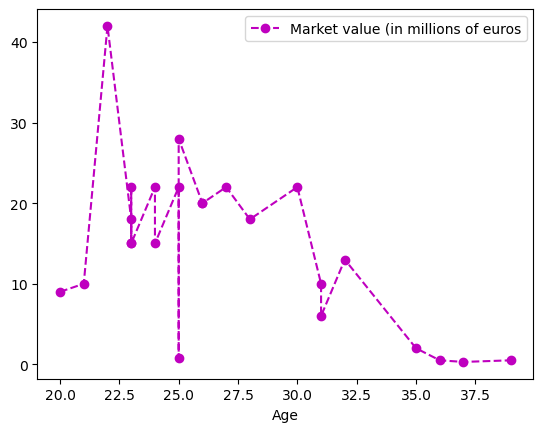

In [72]:
player_df.sort_values('Age',inplace=True)

player_df.plot('Age','Market value (in millions of euros', color='m', linestyle='--', marker='o')